In [399]:
import array as arr
from BTrees.IIBTree import IIBTree # documentation, https://pythonhosted.org/BTrees/ 
import csv
from enum import Enum
import queue    # see https://docs.python.org/3/library/queue.html#module-queue
import math
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
# from matplotlib.collections import Poly3DCollection # https://stackoverflow.com/questions/10599942/drawing-a-rectangle-or-bar-between-two-points-in-a-3d-scatter-plot-in-python-and
# and https://stackoverflow.com/questions/37585340/plotting-3d-polygons-in-python-3
import numpy as np
import random as rand
from trajectory import * # import the trapezoidal trajectory
import time

# interesting/useful websites
# talks about implementing robot simulator: https://www.toptal.com/robotics/programming-a-robot-an-introductory-tutorial  
#    said robot simulator code: https://github.com/nmccrea/sobot-rimulator/blob/v1.0.0/models/supervisor.py

In [400]:
def step(t, dt):
    t = t + dt
    return t

In [401]:
class drawRobot(object):
    def __init__(self):
        self.a = 0
        
    def drawRect(self, q_curr, width_v, length_v):

        xl  = q_curr[0] + width_v / 2  # left x coordinate
        xr  = q_curr[0] - width_v / 2  # right x coordinate

        yf  = q_curr[1] - length_v / 2 # front
        yb  = q_curr[1] + length_v / 2 # back

        verts = []

        xs = [xr, xl, xl, xr, xr]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        ys = [yf, yf, yb, yb, yf]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        z_axis = [0, 0, 0, 0, 0]

        verts = [list(zip(xs, ys, z_axis))]

        poly = Poly3DCollection(verts, facecolors="blue", closed = False)
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
        
    def drawFrame(self, left_edge, back_edge, front_edge, z_edges_f):
        xl  = left_edge  # back x coordinate
        
        yf  = front_edge # front y coordinate
        yb  = back_edge  # back y coordinate

        zt  = z_edges_f[0]  # top z coordinate
        zb  = z_edges_f[1]  # bottom z coordinate

        verts = []
        
        xs = [xl, xl, xl, xl, xl]
        ys = [yf, yb, yb, yf, yf]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        z_axis = [zt, zt, zb, zb, zt]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        
        verts = [list(zip(xs, ys, z_axis))]
        
        poly = Poly3DCollection(verts, closed = False, alpha=0.25)
        poly.set_facecolor("grey")  # the transparency setting (alpha) is overriden by facecolor otherwise
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
    def drawArmCylinder(self, center_y, center_z, arm_start, arm_end):
        # see second answer https://stackoverflow.com/questions/26989131/add-cylinder-to-plot
        radius = 0.2 # set arbitrarily 
        
        x     = np.linspace(arm_start, arm_end, 3)
        theta = np.linspace(0, 2*np.pi, 3)
        
        theta_grid, x_grid = np.meshgrid(theta, x)
        
        y_grid = radius*np.cos(theta_grid) + center_y
        z_grid = radius*np.sin(theta_grid) + center_z
        
        return x_grid,y_grid,z_grid
            

In [402]:
def vehicleStep(q_curr, v, dt):
    # for now it's constant velocity  
    q_new = np.array([q_curr[0] + v[0]*dt, q_curr[1] + v[1]*dt])
    return q_new

In [403]:
class camera(object):
    def __init__(self, length_v, n_row, frame_height):      
        
        #################### CLASS VARIABLES ####################
        self.width = length_v  # width of camera view, in m
        self.i_lastFruit = 0   # last visited fruit index
        
        # lists of coordinates of picked fruits
        self.x      = []
        self.y      = []
        self.z      = []
        self.t_pick = []        # time when fruit was picked
        
        # list of fruits passed by the vehicle
        self.passed_fruit = []
        
        # Settings for the row
        self.row_n  = n_row     # row number, in one sided-version, lower number means lower on the vehicle
        self.height = frame_height # how high of fruit can this row see

        self.mid_location = (  # tuple used to determine the location of the middle of the row
            self.height/2,
            self.height + self.height/2,
            2*self.height + self.height/2
        )
        
        self.row_mid = self.mid_location[self.row_n] # find the row height for this arm => might not need self

        # calculate the up-down edges of the camera once
        self.view_bot = self.row_mid - self.height / 2 # up-down edges
        self.view_top = self.row_mid + self.height / 2
        
#         print("top:", self.view_top, "bottom:", self.view_bot)
        
        # side edges of the camera
        self.view_min = 0.
        self.view_max = 0.
        
        
        ######################## MODULES ########################
        self.fruitBTree    = IIBTree()
        
               
        
    ######################## FUNCTIONS ########################
    def cameraStep(self, end_row, q_curr, sortedFruit):
        # centered (for now) on the vehicle, perpendicular to data's y-axis
        self.view_min = q_curr - self.width / 2 # side edges
        self.view_max = q_curr + self.width / 2
        
        # fix side end constraints of beginning and end 
        if self.view_min < 0:
            self.view_min = 0 # will need to change this to a beginning value like below
            
        j = self.i_lastFruit # the last fruit that was added (so it repeats less)
            
        # do the same but updating a b-tree instead for better searchability
        while(True):
            try:
                if sortedFruit[1,j] > self.view_min and sortedFruit[1,j] < self.view_max:
                    # now check vertical edges
                    if sortedFruit[2,j] > self.view_bot and sortedFruit[2,j] < self.view_top:
                        # now check if it has been picked before
                        if sortedFruit[3,j] == 0:
                            # convert the y-location into an integer so it can be used as a key, ceiling because it's at the edge
                            # so it can't really be used either way as a goal
                            key = math.ceil(sortedFruit[1,j]*1000) 
                            # add the value to the b-tree
                            self.fruitBTree.update({key:j})

                elif sortedFruit[1,j] > self.view_max:
                    # no fruit left to add
                    break
                j = j + 1
            except IndexError:
                print("*** Finished going through available fruit ***")
                break
            
        self.i_lastFruit = j
            
    
    def fruitPicked(self, pointCoord, t):
        self.x.append(float(pointCoord[0]))
        self.y.append(float(pointCoord[1]))
        self.z.append(float(pointCoord[2]))
        self.t_pick.append(float(t))
        
        
    def packFruit(self):
        x_fr = np.array(self.x)
        y_fr = np.array(self.y)
        z_fr = np.array(self.z)
        t    = np.array(self.t_pick)

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        inv_fruit = np.stack([x_fr, y_fr, z_fr, t])
        
        return inv_fruit
        


In [404]:
class scheduler(object):        
        
    def __init__(self, n_goals, num_row, num_arms, v_max, a_max):
        # need to figure out the type of schedule being used 
                      
        #################### CLASS VARIABLES ####################
        self.v_max = v_max
        self.a_max = a_max
        self.d_max = a_max
        
        # robotic system configuration
        self.num_rows     = num_row
        self.num_arms_row = num_arms
        
        total_arms = self.num_rows * self.num_arms_row
        
        # arm mounting frame width, since arms aren't just points in space
        self.mounting_width = 0.2 # should match the cylinder drawn by the draw class 
        
        # variables for the goals
        self.n_goals = n_goals # number of goals the greedy scheduler will find
        # create a matrix of queues that hold the next fruit to pick, one queue per each arm 
        self.goal_queue = np.ndarray((self.num_rows, self.num_arms_row), dtype=object) # create the matrix
        
        for rows in range(self.num_rows):       
            for count in range(self.num_arms_row): 
                self.goal_queue[rows, count] = queue.Queue() # populate the matrix with queue objects
        
        ######################### FLAGS #########################
        # until I can figure out Enum
        
        # Arm cofiguration flags
        self.conf_INDIVIDUAL = 0
        self.conf_SHARED     = 1
        
        ######################## MODULES ########################
  
        
        ################ SELF FUNCTIONS AT INIT #################
        self.trajCalc = Trajectory(self.v_max, self.a_max, self.d_max) # to be able to calculate trajectories              
                    
    def greedyScheduler(self, a, row_picture, fruit, v_v, arm_conf):
        # base setting is with arms as individuals
        
        # keyword parameters in functions, https://treyhunner.com/2018/04/keyword-arguments-in-python/
        
        # get arm or for each arm?
        for rows in range(self.num_rows): 
            
            arm_location = np.zeros([self.num_rows, self.num_arms_row])
            back_edge    = np.zeros([self.num_arms_row, 1])
            front_edge   = np.zeros([self.num_arms_row, 1])
            # variable that adds up times to goal to figure out the edges for the next arm 
            time_tot = []
#             time_tot     = np.zeros([self.num_arms_row, 20])
#             time_drop    = np.zeros([self.num_arms_row, 1])
                        
            for i in range (self.num_arms_row):
                # create a matrix with the starting location values for all three arms
                arm_location[i] = np.copy(a[rows,i].q_a)
                # create arrays for the front and back edges of each arm
                back_edge[i]  = np.copy(a[rows,i].y_edges_f[1])
                front_edge[i] = np.copy(a[rows,i].y_edges_f[0])
                # create a new list in time_tot for each new arm
                time_tot.append([0.])
                
            unpick = [] # list to make sure goals don't repeatedly get checked but are unlisted as picked later
            
            # get list of next X number of fruit and add them to a queue
            for pears in range(n_goals):
                for arm_free in range((self.num_arms_row-1), -1, -1): # as long as the arms are moving back to front picking fruits,
                    # we need to figure out the back arm's location first?
                    if len(row_picture[rows].fruitBTree) > 0:                               
                        
                        # get the location of this arm's back edge and convert to integer to get a value to compare keys                  
                        potential_key = math.floor(back_edge[arm_free]*1000)
                    
                        # find a value in the B-tree that fits the first location 
                        try: # if no key exists after the potential key, break out rather than crash the program
                            key = row_picture[rows].fruitBTree.minKey(potential_key) 
                            index = row_picture[rows].fruitBTree[key]

                            # check that the goal/fruit does not pass the front part of the frame
                            if fruit.sortedFruit[1,index] < front_edge[arm_free]:
                                # choose the first fruit as a goal to be given to the arm
                                goal_new = row_picture[rows].fruitBTree.pop(key)
                                goal_coord = np.copy(fruit.sortedFruit[0:3,goal_new])
                                # calculate the time to the fruit
                                p_time = self.pickTime(arm_location[arm_free,:], goal_coord)

                                # compare with back_edge's location at that point, remove if not possible reach (okay if grabbed before vehicle passes)
                                temp_back_edge = back_edge[arm_free] + v_v[1]*p_time # maybe need to add arm speed?

                                if temp_back_edge < goal_coord[1]:  # for now only the y-coordinate

                                    # add to list, index is given, not the coordinates
                                    self.goal_queue[rows, arm_free].put(goal_new)
                                    # calculate retraction and drop-off times
                                    r_time = self.returnTime(arm_location[arm_free,:], goal_coord, a[rows,arm_free].z_edges_f[1])
                                    # set newest location
                                    arm_location[arm_free,1] = goal_coord[1]          # y-coord goal was last moved y location
                                    arm_location[arm_free,2] = a[rows,arm_free].z_edges_f[1] # b/c of drop off, that's the new z-coordinate
                                    # x location should always end at the starting point x-coord 
                                    
                                    if arm_conf == self.conf_INDIVIDUAL:
                                        # if the arms work in individual spaces, they are only affected by the vehicles's speed
                                        back_edge[arm_free] = back_edge[arm_free] + v_v[1]*(p_time + r_time)
                                        front_edge[arm_free] = front_edge[arm_free] + v_v[1]*(p_time + r_time)
                                        
                                    elif arm_conf == self.conf_SHARED:
                                        # if the arms are sharing the row space, their edges are based on the other arm's velocity
#                                         time_drop[arm_free] = r_time
                                        time_tot[arm_free].append([arm_location[arm_free,1], p_time + r_time])
    
                                        if arm_free == self.num_arms_row-1:
                                            # don't care about the front edge
                                            front_edge[arm_free] = front_edge[arm_free] + v_v[1]*(p_time + r_time)
                                            # maybe: (prolly will have to calculate it?)
                                            back_edge[arm_free]  = arm_location[arm_free-1,1]+ v_v[1]*(p_time + r_time)
                            
                                        elif arm_free == 0:
                                            # don't care about the back edge
                                            back_edge[arm_free] = back_edge[arm_free] + v_v[1]*(p_time + r_time)
                                            # maybe: (prolly will have to calculate it?)
                                            front_edge[arm_free] = arm_location[arm_free+1,1]
                                        
                                        else:
                                            # care about both
                                            front_edge[arm_free] = arm_location[arm_free+1,1]
                                            back_edge[arm_free]  = arm_location[arm_free-1,1] + v_v[1]*(p_time + r_time)
                                        
#                                         print("time list:", time_tot[arm_free])
#                                         print("length of list:", len(time_tot[arm_free+1]))
                                        
                                        # because not all goals are reached at the same time
#                                         for x in range(len(time_tot[arm_free+1]),-1,-1):
#                                             print(time_tot[arm_free+1][x])
                                            
#                                         if time_tot[arm_free][-1] < time_tot[arm_free+1][-1]:
#                                             # if this job does finishes before the last job of the arm in front
#                                                 
                                    # set the index's fruit as picked
                                    fruit.sortedFruit[3,goal_new] = 1 
                                else:
                                    fruit.sortedFruit[3,goal_new] = 1
                                    # however, populate a list of fruit that will go back to being not picked after this
                                    unpick.append(goal_new)

                        except ValueError:
                            print("*** No value came up, broke out of the if statement ***")
#                             break
                            pass
                
                # unpick all the unpickable fruit
                for i in range(len(unpick)):
                    fruit.sortedFruit[3,i] = 0
                    print("Clearing some space")
                                        
                            
    
    def pickTime(self, a_coord, goal):
        # calculate total pick cycle time for a fruit
        
        # calculate x, y and z times as the arm moves from curent position to the goal
        x_time = self.calcTrapTimes(a_coord[0], goal[0], 0.)
        y_time = self.calcTrapTimes(a_coord[1], goal[1], 0.)
        z_time = self.calcTrapTimes(a_coord[2], goal[2], 0.)
        
        time_pick = x_time + max(y_time, z_time)
        
        return(time_pick)
    
    
    def returnTime(self, a_coord, goal, z_bottom):
        # calculate total retract and drop off cycle time for a fruit. Maybe add grip time later?
        
        # calculate x, y and z times as the arm moves from curent position to the goal
        x_time = self.calcTrapTimes(goal[0], a_coord[0], 0.) # opposite :)
        z_time = self.calcTrapTimes(goal[2], z_bottom, 0.)
        
        time_ret = x_time + z_time
        
        return(time_ret)
        
        
    def calcTrapTimes(self, q_start, q_end, v_start):
        # get trapezoidal times
        self.trajCalc.adjInit(q_start, v_start)
        self.trajCalc.noJerkProfile(self.trajCalc.q0, q_end, self.trajCalc.v0, self.v_max, self.a_max, self.d_max)
         
        total_time = self.trajCalc.Ta + self.trajCalc.Tv + self.trajCalc.Td
        
        return(total_time)


    def singleFruitScheduler(self, num_row, num_arms, a, row_picture, fruit):
        # assigns fruit one at a time to each fruit. Not really a scheduler, but useful for testing
        
        # for each row
        for rows in range(num_row):
            # check if there are any arms that are free 
            for arm_free in range(num_arms):
                if a[rows,arm_free].free == 1 and len(row_picture[rows].fruitBTree) > 0:
                    # get the location of this arm's back edge and convert to integer to get a value to compare keys                  
                    potential_key = math.floor(a[rows,arm_free].y_edges_f[1]*1000)
                    # find a value in the B-tree that fits it's location 
                    try: # if no key exists after the potential key, break out rather than crash the program
                        key = row_picture[rows].fruitBTree.minKey(potential_key)
                        index = row_picture[rows].fruitBTree[key]

                        # check that the goal does not pass the front part of the frame
                        if fruit.sortedFruit[1,index] < a[rows,arm_free].y_edges_f[0]+1:
                            # choose the first fruit as a goal to be given to the arm
                            goal_new = row_picture[rows].fruitBTree.pop(key)
                            # set the index's fruit as picked
                            fruit.sortedFruit[3,goal_new] = 1
                            # give the arm the index so that it can set it back to 0 if it does not reach it
                            a[rows,arm_free].goal_index = goal_new
                            # set the new goal
                            a[rows,arm_free].setGoal(fruit.sortedFruit[0:3,goal_new], t_step)                     

                    except ValueError:
                        print("*** No value came up, broke out of the if statement ***")
                        break
                        

In [405]:
class arm(object):        
        
    def __init__(self, q, q_v, n, num_arms, frame_width, frame_height, column_width, row_n, max_vel, max_accel, row_conf):
        
        ## next level would be for them to be seperate threads with access to the global clock -Stavros
        
        ######################### FLAGS #########################
        # until I can figure out Enum
        self.x_move        = 0     # allows the x-dir to start moving
        self.retractFlag   = 0     # checks if the arm is retracting
        self.unloadFlag    = 0     # checks if the arm's moving to the conveyor
        
        # Arm cofiguration flag values
        self.conf_INDIVIDUAL = 0
        self.conf_SHARED     = 1
        
              
        #################### CLASS VARIABLES ####################
        self.n             = n                           # arm number 
        self.row_n         = row_n                       # which row this arm is located in
        self.q_a           = np.array([q[0],q[1],q[2]])  # arm's location in the world's frame of reference
        self.v_a           = np.array([0.,0.,0.])        # arm's current velocity in the three axis
        self.state         = 0                           # arm's state to log % time used for each activity
        self.row_conf      = row_conf                    # sets if the row space is shared or not
        self.num_arms      = num_arms                    # total number of arms in a row
        
        # list of all locations where arm was
        self.qax           = []
        self.qay           = []
        self.qaz           = []
        
        # list of time it took to finish eeach picking cycle
        self.pick_cycle    = []
        self.pick_cycle_s  = 0.  # when the picking cycle timer started
        
        # which fruits were picked and at what time, might only need times if it's being used to determine 
        # the arm's throughput
        self.time_of_picking = []
        
        # frame size
        self.length_f      = 2.5          # how far can it go into trees, in m
        self.width_f       = frame_width  # size of enclosing frame, width in m -> when shared this includes the shared space
        self.height_f      = frame_height # size of enclosing frame, height in m
        self.width_c       = column_width # width of the columns supporting the arms
        
        if self.row_conf == self.conf_SHARED:
            self.width_f    *= self.num_arms # if it's shared space the width is much larger
        
        
        # frame center coordinates
        self.q_f           = np.array([q[0],q_v[1],q[2]])  # frame's center at row and vehicle's center
        
        if self.row_conf == self.conf_INDIVIDUAL:
            self.q_f[1]    = q[1]  # frame's center moves to be individual, rather than the vehicle's center
        
        
        # edges of the frame
        self.x_edges_f     = np.array([0.,0.]) # 0 is the starting position, 1 is max extension
        self.y_edges_f     = np.array([0.,0.]) # 0 is forward, 1 is in the back
        self.z_edges_f     = np.array([0.,0.]) # 0 is the top, 1 is the bottom
        
        if self.row_conf == self.conf_SHARED:
            self.y_edge_end = np.array([0.,0.])
        
        # values for trapezoid trajectory (parameters to play with...)
        self.v_max         = max_vel 
        self.a_max         = max_accel  
        self.d_max         = max_accel 
        
        # can the arm be given a goal, or does it already have one
        self.free          = 1     # start ready to be given a goal 
        self.goal          = np.array([0.,0.,0.])
        self.goal_r        = np.array([0,0,0]) # has the goal been rached at each axis
        self.reached_goals = 0     # how many goals were successfully reached 
        self.goal_index    = 0     # what index did the goal come from 
        self.goals_given   = 0     # how many goals were given to the arm (to check against how many it reached)

        # following the trapezoidal trajectory
        self.t             = 0.      # time at which the arm will begin moving to the goal
        self.tx            = 0.      # time at which the arm will begin moving in the x-dir
        self.tz            = 0.      # time used for unloading the fruit on conveyor (only z-dir)        
        # calculate the error between the final location and given goal coordinates 
        self.error         = np.array([0.,0.,0.])
        
        
        ######################## MODULES ########################
        self.x = Trajectory(self.v_max, self.a_max, self.d_max)
        self.y = Trajectory(self.v_max, self.a_max, self.d_max)
        self.z = Trajectory(self.v_max, self.a_max, self.d_max)   
        
        ################ SELF FUNCTIONS AT INIT #################
        self.initFrame()
        

    ######################## FUNCTIONS ########################
    def armStep(self, v_v, a, dt, t):
        # AAAALLLLL THE AAARMMMSSSSSSSSS
        # v_v is the vehicle's velocity
        # q_curr is the arm's current location within the world frame 
        q_curr      = np.array([self.q_a[0],self.q_a[1],self.q_a[2]])
        
        epsilon     = 0.001           # allowable error when reaching fruit

        goal_time   = t - self.t      # time since the y-z self timer was started
        goal_time_x = t - self.tx     # time since the x self timer was started => not updating correctly
        
        if self.unloadFlag == 2: # if the arm is unloading
            goal_time_z = t - self.t_unload
        else:
            goal_time_z = goal_time 
    
        # move along with the vehicle
        self.moveFrame(v_v, a, dt)       # start with the frame
        
        # check if fruit can still be reached according to frame's location 
        can_reach   = self.reachable()
        
        if can_reach == 1:
            # at the moment trying to cancel the vehicle's velocity/movement's effect on the arms by subtracting it
            # in the y-axis:
            self.calcYVel(goal_time, v_v)
            # in the z-axis:  
            self.calcZVel(goal_time_z)  # not affected by the vehicle's velocity

            # if both y and z goal locations reached, start moving in the x-dir to grab the fruit
            if self.goal_r[1] == 1 and self.goal_r[2] == 1:
                # check that it's the first time this has been reached since a new goal was given
                if self.tx == 0.:        
                    self.tx     = t   # start time for the new timer for x
                    goal_time_x = 0.  # restart the timer for x
                    self.x_move = 1   # allow movement in the x-direction

            if self.x_move == 1: 
                self.calcXVel(goal_time_x, v_v)
              
        elif can_reach == 0:
            # set these at zero and check if arm has to be retracted or fruit unloaded
            # makes sure that these actions can still happen even if the arm's frame has moved beyond the fruit
            self.v_a[1] = 0
            if self.retractFlag == 1: 
#                 print("THE ARRRMMMMMMSSSSS")
#                 print("THEY RETRACT?", self.retractFlag)
                self.calcXVel(goal_time_x, v_v)
    
                if self.goal[0] != 1 or self.goal[1] != 1 or self.goal[2] != 1:
                    # if it's retracting before it reached it's goal, then the fruit was not picked
                    fruit.sortedFruit[3,self.goal_index] = 0
                    print("Fruit skipped")
                    
            elif self.unloadFlag != 0: # and q_curr[0] == self.q_f[0]:
                # move down to the conveyor to drop off the fruit
                self.calcZVel(goal_time_z)
        
        self.q_a[0] = q_curr[0] + self.v_a[0]*dt + v_v[0]*dt # coordinate affected by the vehicle's speed (need to change to reflect the axis)
        self.q_a[1] = q_curr[1] + self.v_a[1]*dt + v_v[1]*dt # coordinate affected by the vehicle's speed
        self.q_a[2] = q_curr[2] + self.v_a[2]*dt 
        
        # stop the arm from extending backwards beyond the back of the frame
        if self.q_a[0] < self.q_f[0]:
            self.q_a[0] = self.q_f[0]
        
        # stop the arm from moving below the bottom of the frame
        if self.q_a[2] < self.q_f[2] - self.height_f / 2:
            self.q_a[2] = self.q_f[2] - self.height_f / 2
            
        # stop the arm from moving front or back beyond it's
        if self.q_a[1] < self.q_f[1] - self.width_f / 2:
            self.q_a[1] = self.q_f[1] - self.width_f / 2
        
        # update the location history (for plotting :) ) 
        self.qax.append(float(self.q_a[0]))
        self.qay.append(float(self.q_a[1]))
        self.qaz.append(float(self.q_a[2]))
        
#         if self.n == 0 and self.row_n == 0:
#             print("")
#             print("Row:", self.row_n, "Arm:", self.n)
#             print("Edges, X:", self.x_edges_f, "Y:", self.y_edges_f, "Z:", self.z_edges_f)
#             print("Goal: {0:.4f}".format(self.goal[0]), " {0:.4f}".format(self.goal[1]), " {0:.4f}".format(self.goal[2]))
#             print("Current location: {0:.4f}".format(self.q_a[0]), " {0:.4f}".format(self.q_a[1]), " {0:.4f}".format(self.q_a[2]))

#             print("")
#             print("Is it free?", self.free)
#             print("Goals reached:", self.goal_r)
#             print("retracting:", self.retractFlag)
#             print("unloading", self.unloadFlag)
#             print("can it reach?", can_reach)
#             print("")
 
        # check if the goal was reached within +/- some error ((corrected and fixed, don't touch unless proof of mistake))
        if (self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1) and self.unloadFlag != 1:
            # I'm not sure I like using the unload flag as the way to limit the number of times it gets into this if 
            if ((self.q_a[0] > (self.goal[0]-epsilon) and self.q_a[0] < (self.goal[0]+epsilon)) and
                (self.q_a[1] > (self.goal[1]-epsilon) and self.q_a[1] < (self.goal[1]+epsilon)) and
                (self.q_a[2] > (self.goal[2]-epsilon) and self.q_a[2] < (self.goal[2]+epsilon))):
                # The number of reached goals is getting over-counted
                self.reached_goals += 1
#                 print("GOAL REACHED")
                # "pick" the fruit
                row_picture[self.row_n].fruitPicked(self.q_a, t)
                # set unloading flag to one so that once retraction finishes, unloading can begin
                self.unloadFlag = 1
                # save the time at which it was picked
                self.time_of_picking.append(float(t))
                fruit.sortedFruit[3,self.goal_index] = 2 # set as really picked
                
        
        # if goal has been reached or the fruit cannot be reached, set free to one so a new goal can be given
        if (self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1) or can_reach == 0:
            # start process of retracting the arm if it has extended at all and if the process has not been started before
            if (self.q_a[0] > self.q_f[0]+epsilon or self.q_a[0] < self.q_f[0]-epsilon) and self.retractFlag == 0: # not equal
                self.retract()
                # restart the x timers
                self.tx     = t      # start time for the new timer for x
                goal_time_x = 0. 
            
            # start the unloadng process if the retraction has finished
            elif self.unloadFlag == 2 and goal_time_z == goal_time: # will only happen once with the AND
                # if retraction is done, but fruit has not been dropped off
                self.unload()
                # restart the timers
                self.t_unload    = t      # start time for the new timer for unloading
                goal_time_z      = 0.
            
            # end the process of going for the goal 
            elif self.retractFlag == 0 and self.unloadFlag != 2:
                # set the arm as free only if there is no need to retract or drop of fthe fruit or fruit cannot be reached
                self.tx         = 0.
                self.x_move     = 0
                # look at time at which picking cycle ended
                if self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1 and self.free == 0:
                    pick_cycle_e = t - self.pick_cycle_s
                    self.pick_cycle.append(pick_cycle_e)
                # restart the goal reached values for all axis when new goal is given
                self.goal_r[0]  = 0
                self.goal_r[1]  = 0
                self.goal_r[2]  = 0
                self.free       = 1 
                # reset the unloading flag 
                self.unloadFlag = 0
                # set state back to idle 
                self.state = 0
               
                
                        
        return self.q_a

    
    def retract(self):
        # retracts the arm 
        self.x.adjInit(self.q_a[0], 0)
        self.x.noJerkProfile(self.q_a[0], self.q_f[0], self.x.v0, self.v_max, self.a_max, self.d_max)
        
#         if self.q_a[0] < self.q_f[0]-0.001:
#             print(" ")
#             print("RETRACTING")
#             print("ARM:", self.n, "ROW:", self.row_n)
#             print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)      
#             print(" ")
#             print("goal:         {0:.4f}".format(self.goal[0]), " {0:.4f}".format(self.goal[1]), " {0:.4f}".format(self.goal[2]))
        self.retractFlag = 1
        self.state = 2
        
    
    def unload(self):
        # calculates the trajectory for the arm from curr position to bottom 
        # of the frame (conveyor location) and sets the flag as run the unload sequence
        # should only run if fruit has been obtained and the arm has retracted
        self.z.adjInit(self.q_a[2], self.v_a[2])
        self.z.noJerkProfile(self.q_a[2], self.z_edges_f[1], self.z.v0, self.v_max, self.a_max, self.d_max)
        # set state to unloading
        self.state = 3
    
    
    def setGoal(self, goal, t):
        self.free = 0
        self.goal = goal
        
        self.x.adjInit(self.q_a[0], 0.) # init each axis with current location and velocity (will need velocity at some point)   
        self.y.adjInit(self.q_a[1], 0.) 
        self.z.adjInit(self.q_a[2], 0.)
        # calculate the trapezoidal times for each of the three movement stages (change to S-curve later)
        self.trapTimes()
        # maybe start time here? => evaluate how that could change things once in real time
        self.t = t
        # start picking cycle time measurement here
        self.pick_cycle_s = t
        # set state as picking 
        self.state = 1
        # increase goals given counter
        self.goals_given += 1
        
        
    def trapTimes(self):
        # get trapezoidal times
        self.x.noJerkProfile(self.x.q0, self.goal[0], self.x.v0, self.v_max, self.a_max, self.d_max) 
        self.y.noJerkProfile(self.y.q0, self.goal[1], self.y.v0, self.v_max, self.a_max, self.d_max)  
        self.z.noJerkProfile(self.z.q0, self.goal[2], self.z.v0, self.v_max, self.a_max, self.d_max)  
        
#         print(" ")
#         print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)
#         print("Y-axis, Ta:", self.y.Ta, "Tv:", self.y.Tv, "Td:", self.y.Td)
#         print("Z-axis, Ta:", self.z.Ta, "Tv:", self.z.Tv, "Td:", self.z.Td) 
#         print(" ")
#         print("reached values, X:", self.x.vr, self.x.ar, self.x.dr)
#         print("reached values, Y:", self.y.vr, self.y.ar, self.y.dr)
#         print("reached values, Z:", self.z.vr, self.z.ar, self.z.dr)        
#         print(" ")
        # as more arms are added, these might need to be made internal to the object
       
    
    def initFrame(self):
        # calculate the edges of the frame
        # the x-dir edge is more of a limit on the extension capabilities of the arm. so it's not symetrical
        self.x_edges_f[0] = self.q_f[0]
        self.x_edges_f[1] = self.q_f[0] + self.length_f
        
        # the height will stay constant throughout
        self.z_edges_f[0] = self.q_f[2] + self.height_f / 2
        self.z_edges_f[1] = self.q_f[2] - self.height_f / 2
        
        # y-dir edges change according to the row space configuration
        if self.row_conf == self.conf_INDIVIDUAL: # the y-dir edge make up individual rectangles
            # front
            self.y_edges_f[0] = self.q_f[1] + self.width_f / 2
            # back
            self.y_edges_f[1] = self.q_f[1] - self.width_f / 2
            
        if self.row_conf == self.conf_SHARED:
            # the y-dir edge are initialized as the whole row minus some space for the other arms
            # front
            self.y_edges_f[0] = self.q_f[1] + (self.width_f) / 2 - (self.num_arms - self.n+1) 
            # back
            self.y_edges_f[1] = self.q_f[1] - (self.width_f) / 2 - self.n
#             self.y_edges_f[1] = self.q_f[1] - (self.width_f*self.num_arms) / 2 - self.n
            
            self.y_edge_end = np.copy(self.y_edges_f)
    

    
    def moveFrame(self, v_v, a, dt):
        
        # x-values are not affected by the other arms (yet?)
        x_coor       = self.q_f[0]           # center of the x-direction in the frame
        self.q_f[0]  = x_coor + v_v[0]*dt # move the center point as the vehicle moves
        
        retract_edge = self.x_edges_f[0]
        extend_edge  = self.x_edges_f[1]
        
        # move x-dir the edges
        self.x_edges_f[0] = retract_edge + v_v[0]*dt
        self.x_edges_f[1] = extend_edge + v_v[0]*dt
        
        
        # calculate the changes in y
        if self.row_conf == self.conf_INDIVIDUAL:
            
            y_coor      = self.q_f[1]         # center of the y-direction in the frame
            self.q_f[1] = y_coor + v_v[1]*dt # move the center point as the vehicle moves
            
            # set the value for the edges
            front_edge  = self.y_edges_f[0]
            back_edge   = self.y_edges_f[1]
            
            self.y_edges_f[0] = front_edge + v_v[1]*dt
            self.y_edges_f[1] = back_edge + v_v[1]*dt
            
        elif self.row_conf == self.conf_SHARED: 
            # set the value for the edges
            # got a truncated version of *a* that only has the other arms in that row
            
            self.y_edge_end += v_v[1]*dt # move the ends with the vehicle
            
            if self.n == 0:
                # backmost arm doesn't deal with arms behind it
                back_edge   = self.y_edges_f[1]
                front_edge  = a[self.n+1].q_a[1] - self.width_c + a[self.n+1].v_a[1]*dt
            
            elif self.n == self.num_arms-1:
                # frontmost arm doesn't deal with arms in front of it
                back_edge   = a[self.n-1].q_a[1] + self.width_c + a[self.n-1].v_a[1]*dt
                front_edge  = self.y_edges_f[0]
                
            else:
                back_edge   = a[self.n-1].q_a[1] + self.width_c + a[self.n-1].v_a[1]*dt
                front_edge  = a[self.n+1].q_a[1] - self.width_c + a[self.n+1].v_a[1]*dt
                
            
            # check that it never goes into space at the edges that would be taken up by the other arms
            if front_edge > self.y_edge_end[0]: 
                front_edge = self.y_edge_end[0]
                
            if back_edge < self.y_edge_end[1]:
                back_edge = self.y_edge_end[1]
                
            # move the edges knowing the vehicle and other arms' velocities, the last bit calculate ahead of time
            self.y_edges_f[0] = front_edge + v_v[1]*dt
            self.y_edges_f[1] = back_edge + v_v[1]*dt
       
    
    def reachable(self):
        # check if the fruit is reachable now or in the "future" => actually, should use trapezoidal calc
        # to see if it can reach. ==> not true. Because the vehicle's speed will be variable, these calculations 
        # will very likely be wrong ==> looking at Zhenghao's work, he assumes constant. However, this is better
        # at the scheduling level
        # ==> becomes just a check for when assuming constant vehicle velocity doesn't work :)        

        if self.goal[0] < self.x_edges_f[1] and self.goal[1] > self.y_edges_f[1]:
            # check if the goal is behind the back edges of the frame or over the extension range of the arm
            # don't need to check the y frame because no goals that pass it can be given (already limited by camera object)
            return 1

        else:
            return 0 

            
            
    def calcXVel(self, goal_time_x, v_v):
        if goal_time_x <= self.x.Ta:
            self.v_a[0] = self.x.v0 + self.x.ar*goal_time_x - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv:
            self.v_a[0] = self.x.vr - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv + self.x.Td:
            self.v_a[0] = self.x.vr - self.x.dr*(goal_time_x - (self.x.Ta + self.x.Tv)) - v_v[0]
        
        else:
            self.v_a[0] = -v_v[0] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[0] = 1
            self.retractFlag = 0
            # if the unloadflag was primed by reaching the goal, move the flag to "unload state on"
            if self.unloadFlag == 1:
                self.unloadFlag = 2
            
    
    def calcYVel(self, goal_time, v_v):
        if goal_time <= self.y.Ta:
            self.v_a[1] = self.y.v0 + self.y.ar*goal_time - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv:
            self.v_a[1] = self.y.vr  - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv + self.y.Td:
            self.v_a[1] = self.y.vr - self.y.dr*(goal_time - (self.y.Ta + self.y.Tv))  - v_v[1]
        
        else:
            self.v_a[1] = -v_v[1] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[1] = 1
            
            
    def calcZVel(self, goal_time):
        if goal_time <= self.z.Ta:
            self.v_a[2] = self.z.v0 + self.z.ar*goal_time

        elif goal_time <= self.z.Ta + self.z.Tv:
            self.v_a[2] = self.z.vr

        elif goal_time <= self.z.Ta + self.z.Tv + self.z.Td:
            self.v_a[2] = self.z.vr - self.z.dr*(goal_time - (self.z.Ta + self.z.Tv))
        else:
            self.v_a[2] = 0.
            self.goal_r[2] = 1
            # set unload flag as done if it was triggered to move at the end of retract 
            if self.unloadFlag == 2:
                self.unloadFlag = 0
        
        
    def pickData(self):
#         x_fr = np.array(self.x)
#         y_fr = np.array(self.y)
#         z_fr = np.array(self.z)
        time_pick = np.array(self.time_of_picking)

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
#         inv_fruit = np.stack([x_fr, y_fr, z_fr, t])
        
        return time_pick  # until I know that the coordinates are needed, just use this
    

In [406]:
class csvRead(object):
    def __init__(self):
        #################### CLASS VARIABLES ####################
        
        
        # open CSV file and populate fruits on grid
        x_fr = []
        y_fr = []
        z_fr = []

        # with open('Applestotheleft.csv', newline='') as csvfile:
        #     spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        #     for row in spamreader:
        #         x_fr.append(float(row[0]))
        #         y_fr.append(float(row[1]))
        #         z_fr.append(float(row[2]))

        with open('Applestotheright.csv', newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            for row in spamreader:
                x_fr.append(float(row[0]))
                y_fr.append(float(row[1]))
                z_fr.append(float(row[2]))

        self.x_fruit = np.array(x_fr)
        self.y_fruit = np.array(y_fr)
        self.z_fruit = np.array(z_fr)
        picked  = np.zeros(len(self.x_fruit))

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        fruit = np.stack([x_fr, y_fr, self.z_fruit, picked])

        rowIndex = 1 # sort based on y-axis
        self.sortedFruit = fruit[ :, fruit[rowIndex].argsort()]


In [407]:
class fruitTreeCreator(object):
    # Class that can create synhetic distributions to populate a matrix for the simulator
    def __init__(self, numFruit_row):
        #################### CLASS VARIABLES ####################
        # fruit coordinate lists
        self.x_fr = []
        self.y_fr = []
        self.z_fr = []
        
        # limits for where the fruit can be added
        self.x_lim = [7.,  8.5]
        self.y_lim = [4.5, 20.]
        self.z_lim = [0.,  9.]
        
        # number of fruit created per row, based on input
        self.numFruit = numFruit_row * 3
        
        # initialize the matrix that will give the fruit information
        self.sortedFruit = np.stack([np.zeros(self.numFruit), np.zeros(self.numFruit), np.zeros(self.numFruit), np.zeros(self.numFruit)])
        
        ###################### ENUMERATIONS ######################
#         class Distribution(Enum):
#             UNIFORM = 0,
#             LINE    = 1,
#             CSV     = 2  # Maybe will be a seperate class?
        
    def fruitLine(self, z):
        # function which creates a line of synthetic fruit to test scheduling algorithms
        # z is the height at which all the fruit will be set (since it's a line!)
        
        for fruit in range(self.numFruit):
            # random x-coord for fruit, based on uniform distribution
            self.x_fr.append(rand.uniform(self.x_lim[0], self.x_lim[1]))
            # random y-coord for fruit, based on uniform distribution
            self.y_fr.append(rand.uniform(self.y_lim[0], self.y_lim[1]))
            # z-coordinate (based on z-coordinates given for each line for each row)
            if fruit % 3 == 0:
                self.z_fr.append(z[0])
                
            elif fruit % 3 == 1:
                self.z_fr.append(z[1])
                
            elif fruit % 3 == 2:
                self.z_fr.append(z[2])
                
        self.fruitTreeOut()

    
    def fruitTreeOut(self):
        # converts list of fruit into arrays to build a matrix used in simulator 
        picked  = np.zeros(len(self.x_fr))

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        fruit = np.stack([self.x_fr, self.y_fr, self.z_fr, picked])

        rowIndex = 1 # sort based on y-axis
        self.sortedFruit = fruit[ :, fruit[rowIndex].argsort()]

In [408]:
# init environment
noise = 0.     # for when it becomes stochastic
end_row = 16.  # end of the row (when the mid-point of vehicle reaches this point it stops)
t = []         # 'global' time
t_step = 0.
dt = 0.01      # 'global' time step size
runs = 0

numFruit_row = 200 # number of fruit in each row (for synthetic distributions only)

# fruit = csvRead()                      # use digitized fruit from real trees 
fruit = fruitTreeCreator(numFruit_row)   # create a synthetic distribution for testing

# create synthetic fruit data in a line to test the robot at heights
fruit_lines = [2., 5., 8.]  # in m
fruit.fruitLine(fruit_lines)

dr = drawRobot()

# create empty list which will save arm states
arm_states = []

# create the flags
class spaceConf(Enum):
    INDIVIDUAL = 0
    SHARED     = 1
    

In [409]:
# init vehicle
num_arms     = 3                 # set number of arms on robot, will determine the length of the robot (for now)
num_row      = 3                 # set the number of rows of arms. Getting it ready to add when one row works

# decide if the arms are in individual or shared spaces
space_config = spaceConf.SHARED

# configure the arm's space 
frame_width  = 3.                # length added to vehicle per arm in the y-direction, if individual spaceing, width of frame
frame_height = 3.                # set the height of the arm's frame

# make the arm take up space within the space (slowly added)
column_width = 0.2         # width of column holding the arm in place

# configure the vehicle
width_v = 1.                     # vehicle width (x-dir, parallel to arms going into canopy)
length_v = frame_width*num_arms  # vehicle length (y-dir parallel to row of trees)

q_v = np.array([6.3,9.])         # starting location
v_v = np.array([0.,0.01])        # in m, constant velocity   => got almost 100% fruit at 0.007m/s with 0.73s/fruit (too slow)

# used to plot the vehicle
qv0 = []
qv1 = []

In [410]:
# init camera
row_picture = []

for rows in range(num_row): # one "camera" object per row on vehicle
    p = camera(length_v, rows, frame_height)
    row_picture.append(p)
    

In [411]:
# init arms

# arm's max velocity and acceleration values
max_v = 1.
max_a = 10.

# array of arm object setup
a = np.ndarray((num_row,num_arms), dtype=object)

# arm_offset = 0.75 / (num_row-1) # divide by num of arms because it's going to be inverted diagonal vs row num
arm_offset = 0. # when using synthetic line distribution

# setup for arm initialization
arm0start_y = q_v[1] - (length_v - frame_width)/2  # arm starting position in the y-dir
q_a_new = np.array([0.,0.,0.])                     # used as a temporary value while calculating arm init positions
            

# for each row
for rows in range(num_row):       
    # initialize the arms in a list
    for count in range(num_arms):      
        # calculate where each new arm should go
        # fruit's in a diagonal, so get the bottom arms closer to the fruit
        # the 0.3 is the zero starting point since it will never be exactly zero if they're extending cylinders
        q_a_new[0] = q_v[0] + 0.3 + ((num_row-1)*arm_offset - arm_offset*rows)
        q_a_new[1] = arm0start_y + frame_width*count # places the arms either in their space or far from each other
        q_a_new[2] = row_picture[rows].row_mid   # place it in the already calculated middle of the row
        # this makes sure it matches the "camera" object's z-location         
        
        # initialize the new arm 
        x = arm(q_a_new, q_v, count, num_arms, frame_width, frame_height, column_width, rows, max_v, max_a, space_config.value)
        # add the arm to the a-list     
        a[rows,count] = x
        
    
# maybe have a configuration file that would initialize the arms 

# for plotting
left_edge  = []
right_edge = []
front_edge = []
back_edge  = []


In [412]:
# init scheduler
goal = np.zeros(3) # does this go here?

n_goals = 20       # number of goals the scheduler will look for, at least for the greedy version

s = scheduler(n_goals, num_row, num_arms, max_v, max_a)

In [413]:
### MAIN CODE ###

## start timer to see how long code takes to execute
start_time = time.time()

##### while loooop!
while(q_v[1] < end_row):
    # env.step
    t_step = step(t_step, dt)
    t.append(float(t_step))    
    
    # vehicle.step 
    q_v = vehicleStep(q_v, v_v, dt) # calculate "instantaneous" location
    
    
    # env.obs / camera... FLASH!
    for rows in range(num_row):
        row_picture[rows].cameraStep(end_row, q_v[1], fruit.sortedFruit) # resulting in a B-Tree of index/coordinates in world frame  
    
    
    if (noise == 1):
        # add some noissse! (to the fruit locations)
        noise = 0 # but not right now
    
    # schedule
#     s.singleFruitScheduler(num_row, num_arms, a, row_picture, fruit)

    if runs % 100 == 0: # don't want to run the scheduler every millisecond
        s.greedyScheduler(a, row_picture, fruit, v_v, space_config.value) 
    # go through the list and give each arm a goal
    for rows in range(num_row):
        # give each free arm in that row a goal
#         for arm_free in range((num_arms), -1, -1):
            for arm_free in range(num_arms):
                if a[rows,arm_free].free == 1:
                    # need to check if there are goals
                    if (not s.goal_queue[rows, arm_free].empty()):
                        # figure out what goal to give it 
                        goal_new = s.goal_queue[rows, arm_free].get()
                        # give the arm the index so that it can set it back to 0 if it does not reach it
                        a[rows,arm_free].goal_index = goal_new
                        # set the new goal
                        a[rows,arm_free].setGoal(fruit.sortedFruit[0:3,goal_new], t_step) 

    
    # have each arm take a step
    for rows in range(num_row):
        for arm2step in range(num_arms):
            q_a = a[rows,arm2step].armStep(v_v, a[rows,:], dt, t_step)
    
    # plotting data     
    qv0.append(float(q_v[0]))
    qv1.append(float(q_v[1]))
    
    left_edge.append(float(q_v[0]))  # set at the center of the vehicle in case the arm is set as diagonal to rach farther fruit
    front_edge.append(float(a[0,0].y_edges_f[0]))
    back_edge.append(float(a[0,0].y_edges_f[1]))
    
    arm_index = 0
    arm_list  = []
    
    # compile at which state each arm ends the loop to add to plot later
    for rows in range(num_row):
        for arm2state in range(num_arms):
            arm_list.append([arm_index, a[rows, arm2state].state])
            arm_index += 1
    
    # save arm states 
    arm_states.append(arm_list)
               
    runs+=1


prog_time = time.time() - start_time

[[0.0], [0.0], [0.0]]
start, end, start velocity: 6.6 7.329938927357909 0.0
start, end, start velocity: 12.0 4.510245912761796 0.0
start, end, start velocity: 1.5 2.0 0.0
start, end, start velocity: 7.329938927357909 6.6 0.0
start, end, start velocity: 2.0 0.0 0.0
start, end, start velocity: 6.6 7.257631869769507 0.0
start, end, start velocity: 9.0 4.515068965629254 0.0
start, end, start velocity: 1.5 2.0 0.0
start, end, start velocity: 7.257631869769507 6.6 0.0
start, end, start velocity: 2.0 0.0 0.0
start, end, start velocity: 6.6 7.375068538962391 0.0
start, end, start velocity: 6.0 4.553468962059391 0.0
start, end, start velocity: 1.5 2.0 0.0
start, end, start velocity: 7.375068538962391 6.6 0.0
start, end, start velocity: 2.0 0.0 0.0
start, end, start velocity: 6.6 7.152058039932959 0.0
start, end, start velocity: 4.510245912761796 9.208550677967658 0.0
start, end, start velocity: 0.0 2.0 0.0
start, end, start velocity: 7.152058039932959 6.6 0.0
start, end, start velocity: 2.0 0.0

start, end, start velocity: 11.22630000000001 5.275132957974661 0.0
start, end, start velocity: 1.9999999999999993 2.0 0.0
start, end, start velocity: 6.6 7.71484891525788 0.0
start, end, start velocity: 11.22640000000001 5.282180473386434 0.0
start, end, start velocity: 1.9999999999999993 2.0 0.0
start, end, start velocity: 6.6 8.160219649797986 0.0
start, end, start velocity: 11.22650000000001 5.345625828549263 0.0
start, end, start velocity: 1.9999999999999993 2.0 0.0
start, end, start velocity: 6.6 7.218963668310196 0.0
start, end, start velocity: 11.22660000000001 5.446362025648519 0.0
start, end, start velocity: 1.9999999999999993 2.0 0.0
[[0.0], [0.0], [0.0]]
start, end, start velocity: 6.6 8.45736560549517 0.0
start, end, start velocity: 11.22670000000001 9.248991476232423 0.0
start, end, start velocity: 1.9999999999999993 2.0 0.0
start, end, start velocity: 6.6 7.732262788901516 0.0
start, end, start velocity: 9.009999999999977 5.551438000278726 0.0
start, end, start velocity:

start, end, start velocity: 3.0 5.0 0.0
start, end, start velocity: 7.2528559540238735 6.6 0.0
start, end, start velocity: 5.0 3.0 0.0
start, end, start velocity: 6.6 7.529721796164123 0.0
start, end, start velocity: 9.350411515222744 9.446698631084159 0.0
start, end, start velocity: 3.0 5.0 0.0
start, end, start velocity: 7.529721796164123 6.6 0.0
start, end, start velocity: 5.0 3.0 0.0
start, end, start velocity: 6.6 8.360194823411486 0.0
start, end, start velocity: 9.446698631084159 9.484015322995209 0.0
start, end, start velocity: 3.0 5.0 0.0
start, end, start velocity: 8.360194823411486 6.6 0.0
start, end, start velocity: 5.0 3.0 0.0
start, end, start velocity: 6.6 7.120691793182107 0.0
start, end, start velocity: 9.484015322995209 9.510717307994799 0.0
start, end, start velocity: 3.0 5.0 0.0
start, end, start velocity: 7.120691793182107 6.6 0.0
start, end, start velocity: 5.0 3.0 0.0
start, end, start velocity: 6.6 8.24013158410505 0.0
start, end, start velocity: 9.51071730799479

start, end, start velocity: 7.023534048582491 6.6 0
start, end, start velocity: 4.999999999999991 3.0 0.0
start, end, start velocity: 7.999999999999991 6.0 0.0
start, end, start velocity: 1.9999999999999993 0.0 0.0
start, end, start velocity: 7.1988560201679395 6.6 0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 4.999999999999991 3.0 0.0
start, end, start velocity: 7.999999999999991 6.0 0.0
start, end, start velocity: 8.062555388556975 6.6 0
start, end, start velocity: 6.6 7.079195028623662 0.0
start, end, start velocity: 4.554468962059293 5.58374787724212 0.0
start, end, start velocity: 0.0 2.0 0.0
start, end, start velocity: 4.999999999999991 3.0 0.0
start, end, start velocity: 7.732262788901519 6.6 0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit

start, end, start velocity: 4.999999999999896 3.0 0.0
start, end, start velocity: 6.600000000000107 8.14792174503144 0.0
start, end, start velocity: 8.375896695113191 7.694113416358632 0.0
start, end, start velocity: 3.1104155709393844e-13 2.0 0.0
start, end, start velocity: 6.600000000000107 8.213833789170428 0.0
start, end, start velocity: 8.37599669511319 7.845431935459144 0.0
start, end, start velocity: 3.1104155709393844e-13 2.0 0.0
start, end, start velocity: 6.600000000000107 7.254478548787304 0.0
start, end, start velocity: 8.37609669511319 8.053455094115737 0.0
start, end, start velocity: 3.1104155709393844e-13 2.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 8.000000000000002 6.0 0.0
start, end, start velocity: 6.600000000000175 8.28560917040185 0.0
start, end, start velocity: 9.33287938258533 6.070459577823339 0.0
start, end, start velocity: 3.0000000000003535 5.0 0.0
start, end, start velocity: 6.600000000000175 7.5782441

[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 7.128885823186861 6.6 0
start, end, start velocity: 7.50553794334103 6.6 0
start, end, start velocity: 7.999999999999763 6.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 7.851809861516578 6.6 0
start, end, start velocity: 1.9999999999998859 0.0 0.0
start, end, start velocity: 7.968171991417003 6.6 0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 7.999846989949394 6.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 5.000000000000142 3.0 0.0
start, end, start velocity: 6.6 7.323734495655016 0.0
start, end, start velocity: 8.178145034376396 8.38998114914814 0.0
start, end, start velocity: 0.0 2.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 6.6 7.6619579639544355 0.0
start, end, start velocity: 8.

start, end, start velocity: 8.402746234778855 6.6 0
start, end, start velocity: 6.6 8.043515936441263 0.0
start, end, start velocity: 8.584624699419358 8.688443712951877 0.0
start, end, start velocity: 0.0 2.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 8.000000000000359 6.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 5.000000000000357 3.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 6.6 8.477400678285127 0.0
start, end, start velocity: 8.692723963489081 12.159771801792154 0.0
start, end, start velocity: 6.405000000000369 8.0 0.0
start, end, start velocity: 8.477400678285127 6.6 0.0
start, end, start velocity: 8.0 6.0 0.0
start, end, start velocity: 6.6 7.917501136825451 0.0
start, end, start velocity: 12.159771801792154 12.201704393855668 0.0
start, end, start velocity: 6.0 8.0 0.0
start, end, start velocity: 7.917501136825451

start, end, start velocity: 6.60000000000035 7.529721796164123 0.0
start, end, start velocity: 9.35041151522258 9.446698631084159 0.0
start, end, start velocity: 3.000000000001064 5.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 6.600000000000989 7.534599460623817 0.0
start, end, start velocity: 9.383224044852184 9.395050953233355 0.0
start, end, start velocity: 6.000000000001064 8.0 0.0
start, end, start velocity: 8.099302764650309 6.6 0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 1.9999999999989782 0.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 7.52972179616363 6.6 0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 7.534599460623319 6.6 0
start, end, start velocity: 4.999999999998936 3.0 0.0
start, end, start velocity: 

start, end, start velocity: 8.173904307557452 6.6 0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 7.8706352081317945 6.6 0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 6.600000000000776 8.014653554274668 0.0
start, end, start velocity: 9.578494050292655 9.59677878734922 0.0
start, end, start velocity: 1.0215951348757635e-12 2.0 0.0
start, end, start velocity: 7.999999999998936 6.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 4.999999999998936 3.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 6.60000000000084 7.783519453324789 0.0
start, end, start velocity: 9.662569722727486 9.666923964139862 0.0
start, end, start velocity: 6.000000000001064 8.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 6.60000000000068 7.933739810210879 0.0
start, 

start, end, start velocity: 6.6 7.914093709252471 0.0
start, end, start velocity: 10.261745689913328 10.285177699877105 0.0
start, end, start velocity: 3.0 5.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 7.187551420680613 6.6 0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 8.218330990542277 6.6 0
start, end, start velocity: 8.000000000001778 6.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 2.0000000000018203 0.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 7.9140937092536365 6.6 0
start, end, start velocity: 6.6 7.02940902600602 0.0
start, end, start velocity: 10.184607859794141 10.215747634981042 0.0
start, end, start velocity: 6.0 8.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 5.000000000001778 3.0 0.0
start, end, start veloc

start, end, start velocity: 6.6 7.7682715196555705 0.0
start, end, start velocity: 10.327973722742431 10.356897768826396 0.0
start, end, start velocity: 3.0 5.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 8.453230357913885 6.6 0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 8.000000000001778 6.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 8.104389944734601 6.6 0
start, end, start velocity: 7.768271519656603 6.6 0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 6.6 8.068431666268584 0.0
start, end, start velocity: 10.429973662033015 10.499012081213845 0.0
start, end, start velocity: 6.0 8.0 0.0
start, end, start velocity: 5.000000000001778 3.0 0.0
start, end, start velocity: 2.0000000000018203 0.0 0.0
[[0.0], [0.0], [0.0]]


start, end, start velocity: 2.0000000000018203 0.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 6.6 7.934566551001051 0.0
start, end, start velocity: 10.629848018561 10.63496969512518 0.0
start, end, start velocity: 3.0 5.0 0.0
start, end, start velocity: 6.6 7.851723848693581 0.0
start, end, start velocity: 10.857175459461898 10.878634889245443 0.0
start, end, start velocity: 0.0 2.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 8.37924127147739 6.6 0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 8.000000000001778 6.0 0.0
start, end, start velocity: 7.934566551002234 6.6 0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 7.851723848694693 6.6 0
[[0.0], [0.0], [

[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 6.6 7.286486096860848 0.0
start, end, start velocity: 11.219072451891638 11.236293130438817 0.0
start, end, start velocity: 0.0 2.0 0.0
start, end, start velocity: 6.6 7.2989006250716475 0.0
start, end, start velocity: 11.256975913938952 11.257385607672003 0.0
start, end, start velocity: 6.0 8.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 7.862406134868605 6.6 0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 5.000000000001778 3.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 7.286486096861454 6.6 0
start, end, start velocity: 7.298900625072262 6.6 0
start, end, start velocity: 2.0000000000018203 0.0 0.0
start, end, start velocity: 8.000000000001778 6.0 0.0
[[0.0], [0.0], [0.0]]


start, end, start velocity: 8.209092371510947 6.6 0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 6.6 8.069339264091226 0.0
start, end, start velocity: 11.314013556060772 11.321654995609514 0.0
start, end, start velocity: 0.0 2.0 0.0
start, end, start velocity: 7.88072829223289 6.6 0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 8.000000000001778 6.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 6.628582633786151 7.623006197359235 0.0
start, end, start velocity: 11.449068190386509 14.340375364917115 0.0
start, end, start velocity: 5.000000000001778 5.0 0.0
start, end, start velocity: 7.623006197359235 6.628582633786151 0.0
start, end, start velocity: 5.0 3.0 0.0
start, end, start velocity: 6.628582633786151 7.954365228192774 0.0
start, end, start velocity: 14.340375364917115 14.347524366649456 0.0
start, end, start velocity: 3.0 5.0 0.0
start, end, start velocit

start, end, start velocity: 6.6 7.322710326042673 0.0
start, end, start velocity: 11.513456471442138 11.523750203385674 0.0
start, end, start velocity: 0.0 2.0 0.0
start, end, start velocity: 8.000000000001778 6.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 8.307827787113398 6.6 0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 6.6 7.290131494958123 0.0
start, end, start velocity: 11.585923608521789 11.650322326995283 0.0
start, end, start velocity: 6.0 8.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 5.000000000001778 3.0 0.0
start, end, start velocity: 7.322710326043314 6.6 0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 2.0000000000018203 0.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 6.6 7.513429111707893 0.0
start, end, start vel

[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 6.6 7.749705036209302 0.0
start, end, start velocity: 12.129108788606137 12.136024052767219 0.0
start, end, start velocity: 3.0 5.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 8.000000000001778 6.0 0.0
start, end, start velocity: 7.744237473206095 6.6 0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 2.0000000000018203 0.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 6.6 7.917501136825451 0.0
start, end, start velocity: 12.159771801792326 12.201704393855668 0.0
start, end, start velocity: 6.0 8.0 0.0
start, end, start velocity: 7.749705036210317 6.6 0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 5.000000000001778 3.0 0.0
start, end, start velocity: 6.6 8.075858661681748 0.0
start, end, start vel

start, end, start velocity: 8.435789136953698 6.6 0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 8.000000000001778 6.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 7.634999999999929 7.01539749492713 0.0
start, end, start velocity: 12.325771172292896 15.334386913686068 0.0
start, end, start velocity: 5.000000000001778 5.0 0.0
start, end, start velocity: 7.01539749492713 7.634999999999929 0.0
start, end, start velocity: 5.0 3.0 0.0
start, end, start velocity: 7.634999999999929 8.102182834058853 0.0
start, end, start velocity: 15.334386913686068 15.358266566962131 0.0
start, end, start velocity: 3.0 5.0 0.0
start, end, start velocity: 8.102182834058853 7.634999999999929 0.0
start, end, start velocity: 5.0 3.0 0.0
start, end, start velocity: 7.634999999999929 7.758411180794161 0.0
start, end, start velocity: 15.358266566962131 15.456529040433587 

start, end, start velocity: 6.6 7.940431605250234 0.0
start, end, start velocity: 12.730243050970548 12.860888484760835 0.0
start, end, start velocity: 3.0 5.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 7.299553663629439 6.6 0
start, end, start velocity: 8.000000000001778 6.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 2.0000000000018203 0.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 6.6 7.953930527158114 0.0
start, end, start velocity: 13.109576091545179 13.2124702280497 0.0
start, end, start velocity: 6.0 8.0 0.0
[[0.0], [0.0], [0.0]]
start, end, start velocity: 6.6 7.128625857735101 0.0
start, end, start velocity: 12.735143505790315 15.680686251127387 0.0
start, end, start velocity: 0.09500000000186874 2.0 0.0
start, end, start velocity: 7.128625857735101 6.6 0.0
start, end, start velocity: 2.0 0.0 0.0
start, end, start v

start, end, start velocity: 8.368307371135172 6.6 0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 7.517462727219879 6.6 0
start, end, start velocity: 7.417347666632898 6.6 0
[[0.0], [0.0], [0.0]]
start, end, start velocity: 7.043307371135249 7.734438037482009 0.0
start, end, start velocity: 13.005642028279755 16.02995598949276 0.0
start, end, start velocity: 2.0000000000018203 2.0 0.0
start, end, start velocity: 7.734438037482009 7.043307371135249 0.0
start, end, start velocity: 2.0 0.0 0.0
start, end, start velocity: 7.043307371135249 7.520280002683069 0.0
start, end, start velocity: 16.02995598949276 16.053190819448393 0.0
start, end, start velocity: 0.0 2.0 0.0
start, end, start velocity: 7.520280002683069 7.043307371135249 0.0
start, end, start velocity: 2.0 0.0 0.0
start, end, start velocity: 7.043307371135249 7.19197584790156 0.0
start, end, start velocity: 16.053190819448393 16.076398549040228 0.0
start, end, start velocity: 0.0 2.

start, end, start velocity: 7.31086661329072 6.6 0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 5.000000000001778 3.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 8.248001906054819 6.6 0
start, end, start velocity: 7.460491723979265 6.6 0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 2.0000000000018203 0.0 0.0
start, end, start velocity: 8.000000000001778 6.0 0.0
start, end, start velocity: 6.6 8.276584088572829 0.0
start, end, start velocity: 13.634637236933044 13.641260560060624 0.0
start, end, start velocity: 3.0 5.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 6.6 8.356127267805281 0.0
start, end, start velocity: 13.273750278928736 13.313366817578334 0.0
start, end, start velocity: 0.0 2.0 0.0
start, end, start veloci

start, end, start velocity: 6.6 7.179842587262075 0.0
start, end, start velocity: 13.812257223239179 13.840924336060548 0.0
start, end, start velocity: 3.0 5.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 6.6 7.59102211140107 0.0
start, end, start velocity: 14.001797383704323 14.07058561384673 0.0
start, end, start velocity: 6.0 8.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 6.6 7.072644735310275 0.0
start, end, start velocity: 13.578784482966347 13.609646262552522 0.0
start, end, start velocity: 0.0 2.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 7.179842587262584 6.6 0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 5.000000000001778 3.0 0.0
start, end, start velocity: 7.591022111401951 6.6 0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velo

start, end, start velocity: 8.365330123211388 6.6 0
start, end, start velocity: 6.6 8.40494781284631 0.0
start, end, start velocity: 14.05596553593751 14.094779278601244 0.0
start, end, start velocity: 0.0 2.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 6.6 7.527517008170235 0.0
start, end, start velocity: 14.178977154646645 14.31618748713304 0.0
start, end, start velocity: 6.0 8.0 0.0
start, end, start velocity: 5.000000000001778 3.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 6.6 7.625528295117666 0.0
start, end, start velocity: 14.389097855064186 14.434706916373418 0.0
start, end, start velocity: 3.0 5.0 0.0
start, end, start velocity: 8.40494781284791 6.6 0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start veloci

[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 6.6 8.123852689445428 0.0
start, end, start velocity: 14.65806940924084 14.7681868808772 0.0
start, end, start velocity: 6.0 8.0 0.0
start, end, start velocity: 8.1514592371866 6.6 0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 6.6 7.416164294506429 0.0
start, end, start velocity: 14.29112741477409 14.338818668521201 0.0
start, end, start velocity: 0.0 2.0 0.0
[[0.0], [0.0], [0.0]]
start, end, start velocity: 6.6 8.216977432165649 0.0
start, end, start velocity: 14.33880981097134 17.39820004776824 0.0
start, end, start velocity: 0.7949999999999505 2.0 0.0
start, end, start velocity: 8.216977432165649 6.6 0.0
start, end, start velocity: 2.0 0.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 5.000000000001778 3.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], 

[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 6.627999999999974 8.255904380037672 0.0
start, end, start velocity: 14.825594664501551 17.53213935712811 0.0
start, end, start velocity: 8.000000000001778 8.0 0.0
start, end, start velocity: 8.255904380037672 6.627999999999974 0.0
start, end, start velocity: 8.0 6.0 0.0
start, end, start velocity: 6.627999999999974 8.276546417741057 0.0
start, end, start velocity: 17.53213935712811 17.539566289271306 0.0
start, end, start velocity: 6.0 8.0 0.0
start, end, start velocity: 8.276546417741057 6.627999999999974 0.0
start, end, start velocity: 8.0 6.0 0.0
start, end, start velocity: 6.627999999999974 7.499614018518397 0.0
start, end, start velocity: 17.539566289271306 17.54034464758628 0.0
start, end, start velocity: 6.0 8.0 0.0
start, end, start velocity: 7.499614018518397 6.627999999999974 0.0
start, end, start velocity: 8.0 6.0 0.0

start, end, start velocity: 6.6 8.286040161831144 0.0
start, end, start velocity: 15.02915697903475 15.202628859771979 0.0
start, end, start velocity: 3.0 5.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 7.698822696087387 6.6 0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
start, end, start velocity: 8.000000000001778 6.0 0.0
start, end, start velocity: 8.097132108263295 6.6 0
[[0.0], [0.0], [0.0]]
start, end, start velocity: 7.532132108263356 8.46035733188839 0.0
start, end, start velocity: 14.590536128387518 17.69742033827886 0.0
start, end, start velocity: 2.0000000000018203 2.0 0.0
start, end, start velocity: 8.46035733188839 7.532132108263356 0.0
start, end, start velocity: 2.0 0.0 0.0
start, end, start velocity: 7.532132108263356 7.543487187671268 0.0
start, end, start velocity: 17.69742033827886 17.743648522406875 0.0
start, end, start velocity: 0.0 2.0 0.0
start, end, start velocity: 7.543487187671268 7.53

*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished 

*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished 

*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
start, end, start velocity: 7.7490048551209565 6.6 0
*** Finished going through available fruit ***
*** Fin

*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
start, end, start velocity: 6.6 7.645575235785928 0.0
start, end, start velocity: 15.266741750684625 15.269792230890323 0.0
start, end, start velocity: 0.

*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished 

[[0.0], [0.0], [0.0]]
start, end, start velocity: 6.6 7.34437803691748 0.0
start, end, start velocity: 15.281987850515158 18.20422141000766 0.0
start, end, start velocity: 0.35499999999995013 2.0 0.0
start, end, start velocity: 7.34437803691748 6.6 0.0
start, end, start velocity: 2.0 0.0 0.0
start, end, start velocity: 6.6 7.00450591751605 0.0
start, end, start velocity: 18.20422141000766 18.277201039067148 0.0
start, end, start velocity: 0.0 2.0 0.0
start, end, start velocity: 7.00450591751605 6.6 0.0
start, end, start velocity: 2.0 0.0 0.0
start, end, start velocity: 6.6 7.943121766806549 0.0
start, end, start velocity: 18.277201039067148 18.32630878126141 0.0
start, end, start velocity: 0.0 2.0 0.0
start, end, start velocity: 7.943121766806549 6.6 0.0
start, end, start velocity: 2.0 0.0 0.0
[[0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0]]
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finish

*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished 

*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished 

*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished 

*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished 

*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished 

*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished 

*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished 

*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished going through available fruit ***
*** Finished 

In [414]:
# print final time
total_fruit_picked = 0

fruit_removal = []
index_rem = []

for rows in range(num_row):
    fruit_removal.append(row_picture[rows].packFruit()) # matrix of picked fruit coordinates and time of picking
    # need to have a list that indexes which fruit each row is to remove when plotting
    index_rem.append(0)


try:
    print("program took:", prog_time, "sec")
except NameError:
    prog_time = time.time() - start_time
    print("***prog_time, and thus the total time, maybe incorrect because the main loop terminated early***")
    
print("total internal time:", t[-1])
print("total vehicle distance moved:", q_v[1]-q_v[0])
print("total number of fruit in CSV file:", len(fruit.x_fr)) # reality check
print("")
print("vehicle speed:", v_v[1], "m/s")
print("max arm velocity:", a[0,0].v_max, "m/s, max arm acceleration:", a[0,0].a_max, "m/s^2")
print("")

avg_pick_cycle = []

print("Rear arms are arm no. 0, bottom row is row no. 0:")

for rows in range(num_row):
    for count in range(num_arms):
        # calculate picking cycle average for each arm
        avg_PC = sum(a[rows,count].pick_cycle)/len(a[rows,count].pick_cycle)
        
        # calculate how many fruit were picked overall
        print("total fruit reached for arm", a[rows,count].n,"in row", rows, "is", a[rows,count].reached_goals, "with an avg. picking cycle time", avg_PC, "sec")
        total_fruit_picked += a[rows,count].reached_goals
        
        avg_pick_cycle.append(avg_PC)
#         print("Arm's average picking cycle time", avg_PC, "sec")
#         print("")

avg_fruit_picked = t[-1] / total_fruit_picked

print("")
print("Total picked fruit:", total_fruit_picked, " and sec/pick fruit:", avg_fruit_picked, "and Avg. total picking cycle:", sum(avg_pick_cycle)/len(avg_pick_cycle), "sec")



program took: 24.436758756637573 sec
total internal time: 700.0099999995084
total vehicle distance moved: 9.700099999983685
total number of fruit in CSV file: 600

vehicle speed: 0.01 m/s
max arm velocity: 1.0 m/s, max arm acceleration: 10.0 m/s^2

Rear arms are arm no. 0, bottom row is row no. 0:
total fruit reached for arm 0 in row 0 is 3 with an avg. picking cycle time 5.956666666666666 sec
total fruit reached for arm 1 in row 0 is 2 with an avg. picking cycle time 5.984999999999929 sec
total fruit reached for arm 2 in row 0 is 104 with an avg. picking cycle time 6.631826923072252 sec
total fruit reached for arm 0 in row 1 is 3 with an avg. picking cycle time 6.576666666666763 sec
total fruit reached for arm 1 in row 1 is 3 with an avg. picking cycle time 6.250000000000157 sec
total fruit reached for arm 2 in row 1 is 104 with an avg. picking cycle time 6.7176699029079145 sec
total fruit reached for arm 0 in row 2 is 2 with an avg. picking cycle time 6.264999999999889 sec
total frui

<IPython.core.display.Javascript object>


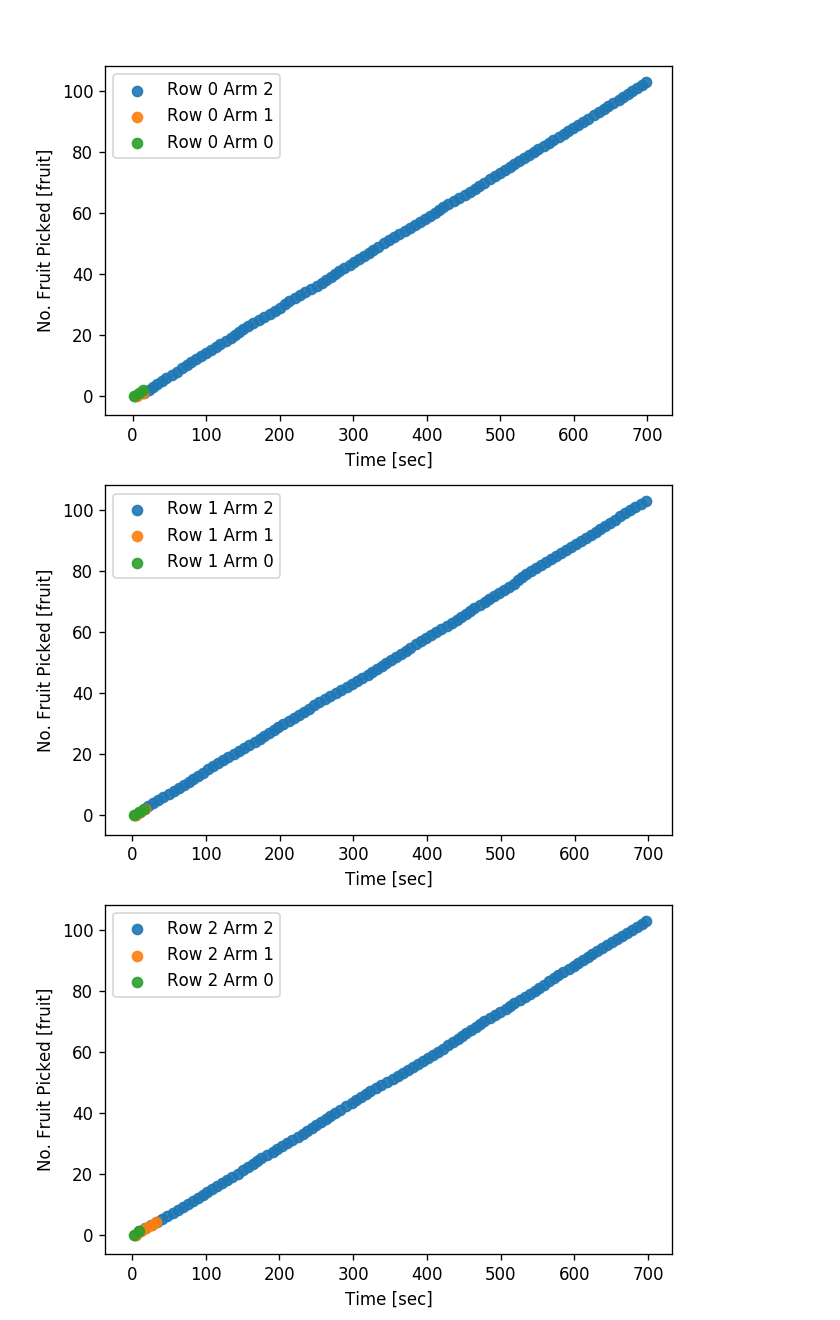

In [415]:
# Plot time versus number of fruit picked per arm
fig, ax = plt.subplots(num_row, figsize=(7, 11))

for rows in range(num_row):
    for manipulators in range((num_arms-1), -1, -1):
        time_apples = np.copy(a[rows,manipulators].pickData())
        apples    = range(np.shape(time_apples)[0])

        
        arm_label = "Row "+str(rows)+" Arm "+str(manipulators)
        
        ax[rows].scatter(time_apples, apples, alpha=0.9, label=arm_label)
        ax[rows].set_xlabel("Time [sec]")
        ax[rows].set_ylabel("No. Fruit Picked [fruit]")
#         ax[rows].set_title("No. of fruit picked versus time")
        ax[rows].legend(loc='upper left', ncol=1)
        
        fig.subplots_adjust(bottom=0.05, top=0.95, right=0.8)
        
        plt.show()
        
        

In [384]:
# analyze the % time each arm is in each state 
idle = 0.
picking = 0.
retracting = 0.
unloading = 0.

tot_num_arms = num_arms*num_row

state_step = 0

state_data = np.zeros((tot_num_arms, len(arm_states)))

for time_step in arm_states:
    for arm_num in time_step:
        state_data[arm_num[0],state_step] = arm_num[1]
        
        if arm_num[1] == 0:
            idle += 1
        elif arm_num[1] == 1:
            picking += 1
        elif arm_num[1] == 2:
            retracting += 1
        elif arm_num[1] == 3:
            unloading += 1
        
    state_step += 1
        
idle_arm = 0.
pick_arm = 0.
retr_arm = 0.
unlo_arm = 0.

row_n = 0
arm_n = 0

# for plotting
idle_plot = []
pick_plot = []
retr_plot = []
unlo_plot = []


# for each arm
for i in range(9):
    for x in state_data[i]:
        if x == 0:
            idle_arm += 1
        elif x == 1:
            pick_arm += 1
        elif x == 2:
            retr_arm += 1
        elif x == 3:
            unlo_arm += 1
    
    total = idle_arm + pick_arm + retr_arm + unlo_arm
    
    idle_plot.append(idle_arm)
    pick_plot.append(pick_arm)
    retr_plot.append(retr_arm)
    unlo_plot.append(unlo_arm)
    
    arm_n += 1
    
    if i%num_row == 0:
        row_n = math.floor(i/num_row)
        arm_n = 0
        
#     print("Arm", arm_n, "in row", row_n)
#     print("Idle:", idle_arm, "[unitless], Picking:", pick_arm, "[unitless], Retracting:", retr_arm, "[unitless], Unloading:", unlo_arm, "[unitless]")
#     print("Idle: {0:.4f}".format(idle_arm/total*100), "[%], Picking: {0:.4f}".format(pick_arm/total*100), "[%], Retracting: {0:.4f}".format(retr_arm/total*100), "[%], Unloading: {0:.4f}".format(unlo_arm/total*100), "[%]")
#     print("")
    
    idle_arm = 0.
    pick_arm = 0.
    retr_arm = 0.
    unlo_arm = 0.



In [416]:
## Functions to add grouping into the arm state percentage plot (and other future plots)
# https://stackoverflow.com/questions/19184484/how-to-add-group-labels-for-bar-charts-in-matplotlib

def mk_groups(data):
    # function takes a dictionary (or anything with an items() method, like collections.OrderedDict) and converts it to a data format that is then used to create the chart. It is basically a list
    try:
        newdata = data.items()
    except:
        return

    thisgroup = []
    groups = []
    for key, value in newdata:
        newgroups = mk_groups(value)
        if newgroups is None:
            thisgroup.append((key, value))
        else:
            thisgroup.append((key, len(newgroups[-1])))
            if groups:
                groups = [g + n for n, g in zip(newgroups, groups)]
            else:
                groups = newgroups
    return [thisgroup] + groups

def add_line(ax, xpos, ypos):
    # creates a vertical line in the subplot at the specified positions (in axes coordinates)
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='black')
    line.set_clip_on(False)
    ax.add_line(line)

def label_group_bar(ax, data):
    # takes a dictionary and creates the subplot with the labels beneath
    groups = mk_groups(data)
    xy = groups.pop()
    x, y = zip(*xy)
    ly = len(y)
    xticks = range(1, ly + 2)

    ax.set_xticks(xticks)
    ax.set_xticklabels(x)
    ax.set_xlim(.5, ly + .5)

    scale = 1. / ly
    for pos in range(ly + 1):
        add_line(ax, pos * scale, -.1)
        
    ypos = -.2
    while groups:
        group = groups.pop()
        pos = 0
        for label, rpos in group:
            lxpos = (pos + .5 * rpos) * scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale, ypos)
        ypos -= .1



<IPython.core.display.Javascript object>


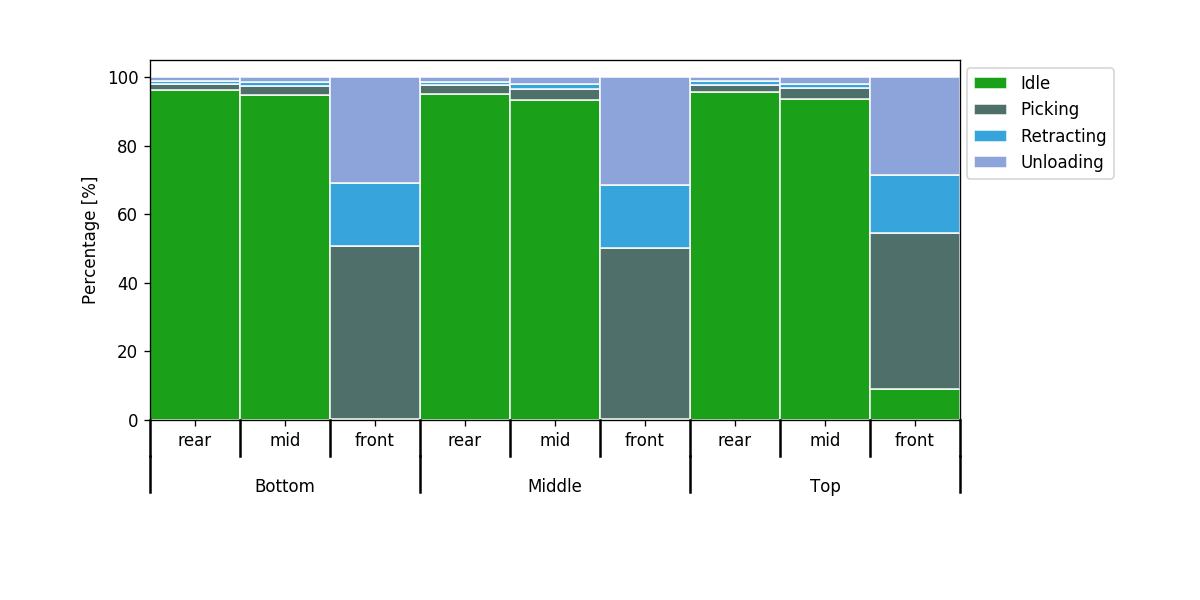

In [417]:
# % stacked bar plot
## https://chrisalbon.com/python/data_visualization/matplotlib_percentage_stacked_bar_plot/

data = {'Bottom':
           {'rear':0,
            'mid':1,
            'front':2
           },
        'Middle':
           {'rear':0,
            'mid':1,
            'front':2
           },
        'Top':
           {'rear':0,
            'mid':1,
            'front':2
           },
       }



# Create a figure with a single subplot
f, ax = plt.subplots(1, figsize=(10,5))

# Set bar width at 1
bar_width = 1

# positions of the left bar-boundaries
bar_l = [i for i in range(1,len(idle_plot)+1)] 

# positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i+(bar_width/2) for i in bar_l] 
# print(tick_pos)

# Create the total steps per state
totals = [i+j+k+l for i,j,k,l in zip(idle_plot, pick_plot, retr_plot, unlo_plot)]

# Create the percentage of the total steps for idle state
per_idle = [i / j * 100 for  i,j in zip(idle_plot, totals)]
# Create the percentage of the total steps for picking state
per_pick = [i / j * 100 for  i,j in zip(pick_plot, totals)]
# Create the percentage of the total steps for retracting state
per_retr = [i / j * 100 for  i,j in zip(retr_plot, totals)]
# Create the percentage of the total steps for unloading state
per_unlo = [i / j * 100 for  i,j in zip(unlo_plot, totals)]

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using idle data
       per_idle, 
       # labeled 
       label='Idle', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#019600',
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

ax.bar(bar_l, 
       # using picking data
       per_pick, 
       # with per_idle
       bottom=per_idle, 
       # labeled 
       label='Picking', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#3C5F5A', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using retracting data
       per_retr, 
       # with per_idle and per_pick on bottom
       bottom=[i+j for i,j in zip(per_idle, per_pick)], 
       # labeled 
       label='Retracting',
       # with alpha
       alpha=0.9, 
       # with color
       color='#219AD8', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using retracting data
       per_unlo, 
       # with all other percents on bottom
       bottom=[i+j+k for i,j,k in zip(per_idle, per_pick, per_retr)], 
       # labeled 
       label='Unloading',
       # with alpha
       alpha=0.9, 
       # with color
       color='#819AD8', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )


ax.set_ylabel("Percentage [%]")

# grouping x-axis values
label_group_bar(ax, data)
f.subplots_adjust(bottom=0.3, top=0.9, right=0.8)
# f.subplots_adjust()

# rotate axis labels
# plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')

# create legend outside of plot
# see https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot/43439132#43439132
ax.legend(bbox_to_anchor=(1.2, 1), loc='upper right', ncol=1)

# shot plot
plt.show()

In [347]:
# total values 
idle_time_all_arms = idle*dt
picking_time_all_arms = picking*dt
retracting_time_all_arms = retracting*dt
unloading_time_all_arms = unloading*dt

print("total time spent idle for all arms:", idle_time_all_arms, "sec")
print("total time spent picking for all arms:", picking_time_all_arms, "sec")
print("total time spent retracting for all arms:", retracting_time_all_arms, "sec")
print("total time spent unloading for all arms:", unloading_time_all_arms, "sec")

total_time = (idle_time_all_arms + picking_time_all_arms + retracting_time_all_arms + unloading_time_all_arms) # / (num_arms*num_row_arms)

print("total time all arms:", total_time, "sec") 
print("Which totals internal simulator seconds multiplied by number of arms")

percent_idle = (idle_time_all_arms / total_time) * 100
percent_picking = (picking_time_all_arms / total_time) * 100
percent_retracting = (retracting_time_all_arms / total_time) * 100
percent_unloading = (unloading_time_all_arms / total_time) * 100

print("")
print("For all arms:")
print("% time idle:", percent_idle, "% time picking:", percent_picking, "% time retracting:", percent_retracting, "% time unloading:", percent_unloading)

total time spent idle for all arms: 3985.4700000000003 sec
total time spent picking for all arms: 1163.84 sec
total time spent retracting for all arms: 434.06 sec
total time spent unloading for all arms: 716.72 sec
total time all arms: 6300.090000000001 sec
Which totals internal simulator seconds multiplied by number of arms

For all arms:
% time idle: 63.260524849644995 % time picking: 18.473386888123816 % time retracting: 6.889742844943483 % time unloading: 11.376345417287688


In [418]:
# Calculate how many goals wer given to each arm and how many of those were reached
for rows in range(num_row):
    for count in range(num_arms):
        given = a[rows, count].goals_given
        reached = a[rows, count].reached_goals
        percent_reached = (reached / given) * 100
        
        print("For arm", count, "row", rows)
        print("Number of goals given:", given, "number of goals reached:", reached)
        print("Percent reached goals:", percent_reached, "%")
        print("")

For arm 0 row 0
Number of goals given: 3 number of goals reached: 3
Percent reached goals: 100.0 %

For arm 1 row 0
Number of goals given: 7 number of goals reached: 2
Percent reached goals: 28.57142857142857 %

For arm 2 row 0
Number of goals given: 143 number of goals reached: 104
Percent reached goals: 72.72727272727273 %

For arm 0 row 1
Number of goals given: 3 number of goals reached: 3
Percent reached goals: 100.0 %

For arm 1 row 1
Number of goals given: 8 number of goals reached: 3
Percent reached goals: 37.5 %

For arm 2 row 1
Number of goals given: 138 number of goals reached: 104
Percent reached goals: 75.36231884057972 %

For arm 0 row 2
Number of goals given: 2 number of goals reached: 2
Percent reached goals: 100.0 %

For arm 1 row 2
Number of goals given: 6 number of goals reached: 5
Percent reached goals: 83.33333333333334 %

For arm 2 row 2
Number of goals given: 142 number of goals reached: 104
Percent reached goals: 73.23943661971832 %



num runs 70001


<IPython.core.display.Javascript object>


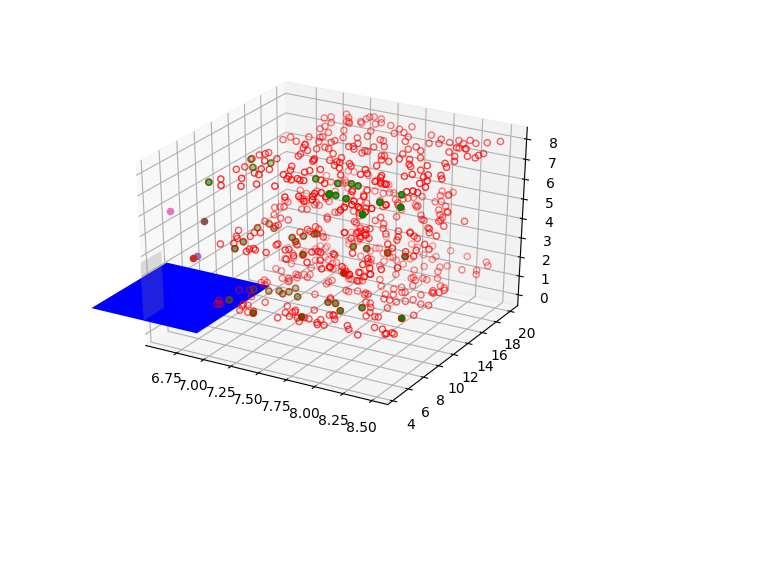

KeyboardInterrupt: 

In [419]:
## plot the vehicle's movement (add other parts as they get finished)    
print("num runs", runs)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion() 

fig.show()
fig.canvas.draw()

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

for run in range(runs):
    time_of_loop = t[run]
    
    if run % 60 == 0:
        ax.clear()
        
        for rows in range(num_row):
            # check if any fruit was picked at this time
            try:        
                # is the if needed when there is a try? => yup, otherwise the points appear at random times
                if fruit_removal[rows][3, index_rem[rows]] < time_of_loop:
                    # add the fruit index to be "removed"
                    index_rem[rows] += 1
            except IndexError:
                print("** Index grew faster than it should have? **")
                print("Index to remove:", index_rem[rows], "in row:", rows, "time:", time_of_loop)
                print("current time value of fruit_removal:", fruit_removal[rows][3, index_rem[rows]-1])
        
        ax.scatter(fruit.sortedFruit[0,:], fruit.sortedFruit[1,:], fruit.sortedFruit[2,:], facecolors='none', edgecolors='r')
        
        for rows in range(num_row):
            ax.scatter(fruit_removal[rows][0,:index_rem[rows]], fruit_removal[rows][1,:index_rem[rows]], fruit_removal[rows][2,:index_rem[rows]], c='g', marker='o')
            
        q_vehicle = [qv0[run], qv1[run]]
        dr.drawRect(q_vehicle, width_v, length_v) # try and draw the vehicle moving along the orchard
        dr.drawFrame(left_edge[run], back_edge[run], front_edge[run], a[0,0].z_edges_f)

        for rows in range(num_row):
            for count in range(num_arms):
                ax.scatter(a[rows,count].qax[run], a[rows,count].qay[run], a[rows,count].qaz[run])
                # need to switch this to a cylinder
                xc, yc, zc = dr.drawArmCylinder(a[rows,count].qay[run], a[rows,count].qaz[run], a[rows,count].q_f[0], a[rows,count].qax[run])
                ax.plot_surface(xc, yc, zc)


        ax.set_xlim(6, 12)
        ax.set_zlim(-1, 11)
        
        ax.set_ylim(q_v[0], end_row+3)
        
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')

        fig.canvas.draw()
        time.sleep(0.005)
       
    
    
fig.show()



In [420]:
# need to print all the fruit that remains unpicked
miss  = 0
sched = 0 
pick  = 0

# prints all the fruit that has not been picked
for x in range(len(fruit.sortedFruit[1])):
    if fruit.sortedFruit[:,x][3] == 0:
#         print(x)
        miss += 1
    elif fruit.sortedFruit[:,x][3] == 1:
        sched += 1
    elif fruit.sortedFruit[:,x][3] == 2:
        pick += 1
        

        
print("Total missed fruit:", miss)
print("Total scheduled, but not picked fruit:", sched)
print("Total picked fruit:", pick)

print("")
print("They add up to:", miss+sched+pick)
print("Total unpicked fruit:", miss+sched)

Total missed fruit: 45
Total scheduled, but not picked fruit: 226
Total picked fruit: 329

They add up to: 600
Total not picked fruit: 271
